In [1]:
%matplotlib inline

In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np
import GPy
import GPyOpt

## Introduction
In the following, we tune the hyperparameters for logistic regression on the MNIST dataset. The tuning is performed by Bayesian optimisation. 

## Import MNIST data

In [3]:
from sklearn.datasets import fetch_mldata
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
# Choosing n_iter for SGDClassifier is deprecated but we need it to reproduce our result
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [5]:
# Load dataset and make sure to shuffle it
mnist = fetch_mldata('MNIST original')
X = mnist.data.astype('float64')
y = mnist.target
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

In [128]:
print("Size of data = {}".format(X.shape))

Size of data = (70000, 784)


In [129]:
train_samples = 5000
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [130]:
X_train.shape

(5000, 784)

## Define model and search space

Four hyperparameter to tune:
 1. Learning rate for SGD $\in [0,1]$ (log scale)
 2. $l_2$ regularisation parameter $\in [0,1]$
 3. Number of learning epochs $\in [5,2000]$
 4. Mini-batch size $\in [20,2000]$
 

In [8]:
def next_batch(X, y, batch_size):
    for i in np.arange(0, X.shape[0], batch_size):
        yield (X[i:i + batch_size], y[i:i + batch_size])

In [134]:
classes = np.unique(y)
gamma = 0.05                    # learning rate
alpha = 50. / train_samples     # l2 regulariser
n_iter = 100                    # learning epochs
batch_size = 200                # mini batch size

clf = SGDClassifier(loss = 'log',
                    penalty = 'l2',
                    alpha = alpha,
                    learning_rate = 'constant',
                    eta0 = gamma,
                    n_iter = 1)

In [139]:
start = time.time()
for i in range(n_iter):
    for (X_batch, y_batch) in next_batch(X_train, y_train, batch_size):
        clf.partial_fit(X_batch, y_batch, classes=classes)
end = time.time()

sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
print("Sparsity with L2 penalty: %.2f%%" % sparsity)
print("Test score with L2 penalty: %.4f" % score)
print("Time elapsed: {}".format(end-start))

Sparsity with L2 penalty: 14.29%
Test score with L2 penalty: 0.7825
Time elapsed: 14.0815160275


## Wrapper function for scoring model

In [143]:
def fit_svr_val(x):
    x = np.atleast_2d(x)
    #fs = np.zeros((x.shape[0],1))
    #fs[i] = 0
    gamma = np.exp(x[0,0]) # log scale
    alpha = np.exp(x[0,1]) # log scale
    n_iter = int(x[0,2])
    batch_size = int(x[0,3])
    clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha, 
                        learning_rate='constant', eta0=gamma, 
                        n_iter=1)
    for i in range(n_iter):
        for (X_batch, y_batch) in next_batch(X_train, y_train, batch_size):
            clf.partial_fit(X_batch, y_batch, classes=classes)
    #clf.fit(X_train,y_train)
    score = clf.score(X_test, y_test)
    return 1 - score # classification error

In [144]:
x = np.array([-2, np.log(50 / train_samples), 100, 200])
start = time.time()
print(fit_svr_val(x))
end = time.time()
print("Time elapsed: {}".format(end-start))

0.1684
Time elapsed: 14.4339849949


## Bayesian Optimisation

 - Acquisition type and weight?

In [147]:
domain =      [{'name': 'gamma_log','type': 'continuous', 'domain': (-6,0)}, 
               {'name': 'alpha_log','type': 'continuous', 'domain': (-6,0)},
               {'name': 'n_iter','type': 'discrete', 'domain': (5,20)},
               {'name': 'batch_size','type': 'discrete', 'domain': (20,2000)}]

In [148]:
start = time.time()
n_dim = len(domain)
n_initial = 5 * n_dim
opt = GPyOpt.methods.BayesianOptimization(f = fit_svr_val,                   
                                          domain = domain, 
                                          model_type = 'GP',
                                          acquisition_type = 'EI',
                                          exact_feval = True,
                                          initial_design_numdata = n_initial, 
                                          initial_design_type = 'random',
                                          num_cores = 2)   
opt.run_optimization(max_iter = 50)
end = time.time()
print("Time elapsed: {}".format(end-start))

Time elapsed: 276.080141783


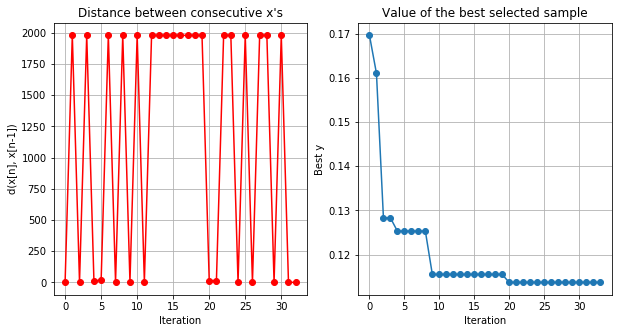

In [149]:
opt.plot_convergence()

In [150]:
min_index = np.argmin(opt.Y)
x_best = opt.X[min_index,:]
y_best = opt.Y[min_index,:]

print(x_best)
print(y_best)

[ -5.56432376  -4.64643485  20.          20.        ]
[ 0.1137]


In [151]:
print(fit_svr_val(x_best))

0.1148


In [152]:
opt.save_report("mnist")

## Compare with random search

In [153]:
from GPyOpt.experiment_design import initial_design

In [154]:
n_initial = 70
X_random = initial_design('random', opt.space, n_initial)

In [ ]:
y_random_opt = float('inf')
#x_history = np.zeros((n_initial, n_dim))
y_history = np.zeros((n_initial))
y_best_history = np.zeros((n_initial))
for i in range(n_initial):
    x_current = X_random[i,:]
    y_current = fit_svr_val(x_current)
    if y_current < y_random_opt:
        y_random_opt = y_current
        x_random_opt = x_current
    y_history[i] = y_current
    y_best_history[i] = y_random_opt
    
print(x_random_opt)
print(y_random_opt)

In [ ]:
fit_svr_val(x_random_opt)